In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Input, Flatten
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from indicators.syncind import SyncInd
from indicators.classic import SMA, Alligator, SmoothMA, RSI, MACD, ATR, WMA, EMA, RMA, VolumeROC
from indicators.candle import OHLC

In [4]:
import time, datetime
from fyers_apiv3 import fyersModel
client_id = "ZHQ4IJL7TI-100"
with open("access_token", "r") as f:
    access_token = f.read()

fyers = fyersModel.FyersModel(client_id=client_id, is_async=False, token=access_token, log_path="")

In [5]:
date_today = datetime.datetime.now().strftime("%Y-%m-%d")
date_100_p = (datetime.datetime.now() - datetime.timedelta(days=100)).strftime("%Y-%m-%d")
date_today, date_100_p

('2024-11-21', '2024-08-13')

In [6]:
response = fyers.history(data={"symbol": "NSE:ZEEL-EQ",
                                "resolution": "1",
                                 "date_format": "1",
                                "range_from": date_100_p,
                                "range_to": date_today,
                                "cont_flag": "1"
                                })

len(response['candles']), response

(25935,
 {'candles': [[1723520700, 136.65, 137.3, 136.49, 137.24, 104552],
   [1723520760, 137.24, 137.24, 136.85, 136.95, 59548],
   [1723520820, 136.95, 137.15, 136.86, 137.05, 45886],
   [1723520880, 137.05, 137.05, 136.85, 136.89, 23903],
   [1723520940, 136.8, 136.89, 136.68, 136.77, 29208],
   [1723521000, 136.77, 136.79, 136.25, 136.3, 40240],
   [1723521060, 136.42, 136.62, 136.32, 136.61, 28461],
   [1723521120, 136.61, 136.95, 136.55, 136.95, 47602],
   [1723521180, 136.95, 136.97, 136.82, 136.94, 12776],
   [1723521240, 136.94, 136.94, 136.7, 136.7, 10933],
   [1723521300, 136.76, 136.93, 136.7, 136.92, 10906],
   [1723521360, 136.85, 136.9, 136.57, 136.64, 24140],
   [1723521420, 136.64, 136.8, 136.59, 136.8, 9005],
   [1723521480, 136.67, 136.91, 136.67, 136.91, 6432],
   [1723521540, 136.93, 137, 136.92, 137, 18301],
   [1723521600, 136.99, 137, 136.79, 136.8, 13836],
   [1723521660, 136.8, 136.92, 136.66, 136.67, 51735],
   [1723521720, 136.67, 136.87, 136.67, 136.87, 94

In [7]:
candles = np.array(response['candles'])
type(candles), candles

(numpy.ndarray,
 array([[1.72352070e+09, 1.36650000e+02, 1.37300000e+02, 1.36490000e+02,
         1.37240000e+02, 1.04552000e+05],
        [1.72352076e+09, 1.37240000e+02, 1.37240000e+02, 1.36850000e+02,
         1.36950000e+02, 5.95480000e+04],
        [1.72352082e+09, 1.36950000e+02, 1.37150000e+02, 1.36860000e+02,
         1.37050000e+02, 4.58860000e+04],
        ...,
        [1.73218302e+09, 1.18420000e+02, 1.18450000e+02, 1.18330000e+02,
         1.18350000e+02, 4.36910000e+04],
        [1.73218308e+09, 1.18260000e+02, 1.18330000e+02, 1.18150000e+02,
         1.18150000e+02, 1.52701000e+05],
        [1.73218314e+09, 1.18000000e+02, 1.18000000e+02, 1.17500000e+02,
         1.17990000e+02, 2.65994000e+05]]))

In [8]:
sync = SyncInd( 
    SMA(5),
    SMA(15),
    Alligator(),
    RSI(),
    ATR(),
    VolumeROC(),
                
)
                
for c in candles:
    sync.append(c)

In [9]:
sync.data()[50:52]

array([[1723523712.0, 136.4199981689453, 136.5, 136.4199981689453,
        136.4600067138672, 3048.0, 136.54, 136.62, 136.9, 136.9, 136.57,
        41.26417041303603, 0.18425590659263338, -67.76990588981707],
       [1723523712.0, 136.47999572753906, 136.58999633789062,
        136.47000122070312, 136.47999572753906, 5107.0, 136.49, 136.59,
        136.91, 136.88, 136.56, 42.025998952790864, 0.18038048469315923,
        -66.9983844911147]], dtype=object)

In [10]:
X, y = [], []

last_candles_count = 8
next_candles_count = 3

temp = []
for ind, i in enumerate(sync.data()):
    k = i.tolist()
    temp.append(k[1:5] + k[6:]) # deleting date and volume from the data
current_data = np.array(temp, dtype=np.float32)
# current_data = sync.data()[:, 1:]

for ind in range(50+(last_candles_count), current_data.shape[0]-50-(next_candles_count-1)):

    first_candle = current_data[ind-last_candles_count]
    temp = []
    for i in range(1, last_candles_count):
        temp.append(first_candle - current_data[(ind-last_candles_count)+i])

    X.append(temp)
    temp = []
    for j in range(next_candles_count):
        temp.append((first_candle - current_data[(ind + j)])[1])
    y.append(temp)
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

In [11]:
X[0]

array([[-5.9997559e-02, -8.9996338e-02, -5.0003052e-02, -1.9989014e-02,
         4.9987793e-02,  2.9998779e-02, -1.0009766e-02,  1.9989014e-02,
         1.0009766e-02, -7.6182556e-01,  3.8754344e-03, -7.7152252e-01],
       [-2.9998779e-02,  9.9945068e-03,  6.9992065e-02,  9.0011597e-02,
         8.9996338e-02,  4.9987793e-02, -1.0009766e-02,  3.9993286e-02,
         4.0008545e-02,  2.2364693e+00,  6.7597479e-03, -6.5696063e+02],
       [ 5.9997559e-02,  1.3999939e-01,  9.9990845e-02,  1.0000610e-01,
         1.3999939e-01,  8.0001831e-02, -1.0009766e-02,  8.9996338e-02,
         8.0001831e-02,  2.5071754e+00,  1.5866622e-02,  1.1952362e+01],
       [ 8.0001831e-02,  0.0000000e+00,  8.0001831e-02, -3.9993286e-02,
         1.1000061e-01,  9.9990845e-02, -1.0009766e-02,  1.3999939e-01,
         9.0011597e-02, -3.2910957e+00,  1.6465858e-02,  2.1784462e+01],
       [-8.0001831e-02, -3.9993286e-02,  2.9998779e-02, -7.9986572e-02,
         8.9996338e-02,  9.9990845e-02, -1.0009766e-02,  1.6

In [12]:
X = tf.constant(X, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.05, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((24533, 7, 12), (24533, 3), (1292, 7, 12), (1292, 3))

In [13]:
model = Sequential()
model.add(Input(shape=X_train.shape[1:]))
model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(next_candles_count))
# model.add(Reshape(y_train.shape[1:]))
model.compile(optimizer='adam', loss='mse')

In [19]:
history = model.fit(X_train, y_train, epochs=500, batch_size=128)#, validation_split=0.2)

Epoch 1/500
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.1653
Epoch 2/500
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.1225
Epoch 3/500
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.1387
Epoch 4/500
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.1344
Epoch 5/500
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.1607
Epoch 6/500
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.1378
Epoch 7/500
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.1595
Epoch 8/500
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.1466
Epoch 9/500
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.1390
Epoch 10/500
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.1624
Epoch 11/500
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.1149
Epoch 12/500
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.1449
Epoch 13/500
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.1322
Epoch 14/500
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.1459
Epoch 15/500
192/192 ━━━━━━━━

In [20]:
X.shape, y.shape

(TensorShape([25825, 7, 12]), TensorShape([25825, 3]))

In [21]:
y_pred = model.predict(X_test)
y_pred

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([[-0.15862246, -0.15563446, -0.1437416 ],
       [ 0.13673158,  0.1271069 ,  0.13140605],
       [-0.13022108, -0.13813424, -0.13291675],
       ...,
       [-0.30239597, -0.3210081 , -0.33127806],
       [ 0.05738714,  0.06928702,  0.08550362],
       [-0.07452122, -0.06788013, -0.0577462 ]], dtype=float32)

In [22]:
for y_p, y_t in zip(y_pred, y_test):
    print("\n", (y_t[0]-y_p[0]), "\t", (y_t[1]-y_p[1]), "\t", (y_t[2]-y_p[2]))


 0.108627036 	 0.18563324 	 0.13373946

 0.10327391 	 0.11289859 	 0.14859273

 0.16021986 	 0.16813302 	 0.20292407

 -0.017401382 	 0.047209293 	 0.11739926

 0.18805611 	 0.11818385 	 0.06185609

 0.055184484 	 0.04391116 	 -0.009050757

 -0.010434166 	 -0.057978883 	 -0.2591874

 0.029064253 	 0.022207603 	 0.032159768

 0.09005898 	 0.050935462 	 -0.50665647

 -0.06080419 	 -0.01151669 	 0.04408838

 0.2760266 	 0.626508 	 0.5997398

 -0.053282462 	 -0.09006886 	 -0.020172924

 0.027556986 	 0.0350701 	 0.039181948

 0.047805756 	 0.11302701 	 0.10217197

 -0.06708945 	 -0.23094699 	 -0.24385582

 0.08657223 	 0.079913616 	 0.16317976

 0.028759584 	 -0.4596421 	 -0.37932676

 -0.07170282 	 0.13615316 	 -0.059979558

 -0.037288055 	 -0.02842927 	 0.02388747

 0.044337913 	 0.047891647 	 0.055613548

 -0.11548938 	 -0.09282529 	 -0.107208

 0.025435 	 0.07638413 	 -0.07246746

 -0.0658211 	 -0.017029285 	 0.047508374

 0.09693381 	 0.13167751 	 0.131698

 -0.022772431 	 0.02172051

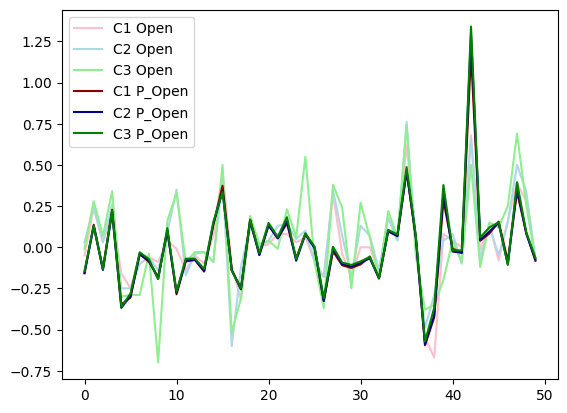

In [23]:
# Example for the first feature (e.g., Close price)
plt.plot(y_test[:50, 0], label='C1 Open', color="pink")
plt.plot(y_test[:50, 1], label='C2 Open', color="lightblue")
plt.plot(y_test[:50, 2], label='C3 Open', color="lightgreen")
plt.plot(y_pred[:50, 0], label='C1 P_Open', color="darkred")
plt.plot(y_pred[:50, 1], label='C2 P_Open', color="darkblue")
plt.plot(y_pred[:50, 2], label='C3 P_Open', color="green")
plt.legend()
plt.show()

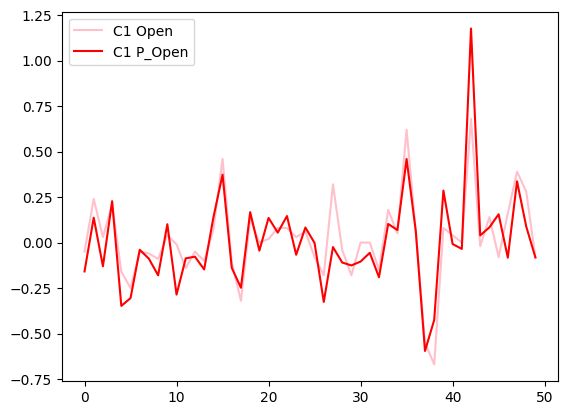

In [24]:
plt.plot(y_test[:50, 0], label='C1 Open', color="pink")
# plt.plot(y[0:5, 1], label='C2 Open', color="blue")
# plt.plot(y[0:5, 2], label='C3 Open', color="green")
plt.plot(y_pred[:50, 0], label='C1 P_Open', color="red")
# plt.plot(y_pred[0:5, 1], label='C2 P_Open', color="darkblue")
# plt.plot(y_pred[0:5, 2], label='C3 P_Open', color="darkgreen")
plt.legend()
plt.show()

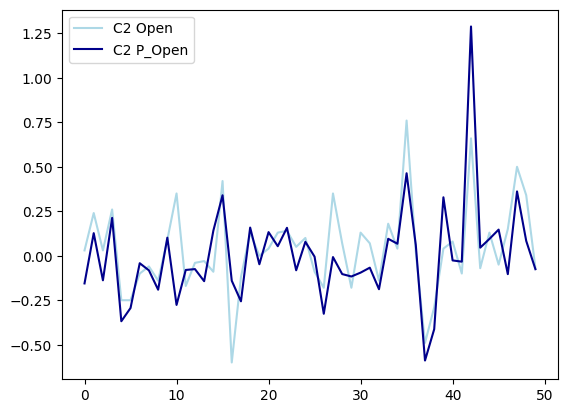

In [25]:
plt.plot(y_test[:50, 1], label='C2 Open', color="lightblue")
# plt.plot(y[0:5, 2], label='C3 Open', color="green")
# plt.plot(y_pred[0:5, 0], label='C1 P_Open', color="darkred")
plt.plot(y_pred[:50, 1], label='C2 P_Open', color="darkblue")
# plt.plot(y_pred[0:5, 2], label='C3 P_Open', color="darkgreen")
plt.legend()
plt.show()

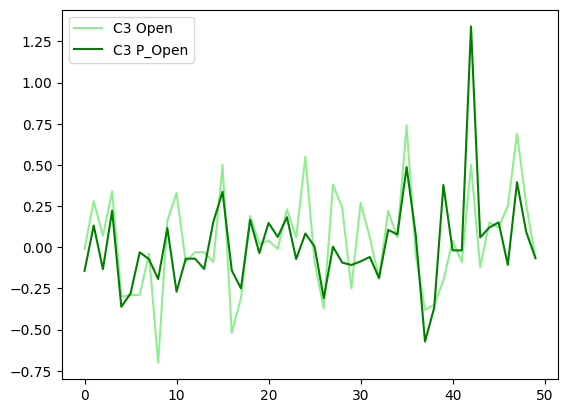

In [26]:
plt.plot(y_test[:50, 2], label='C3 Open', color="lightgreen")
# plt.plot(y_pred[0:5, 0], label='C1 P_Open', color="darkred")
# plt.plot(y_pred[0:5, 1], label='C2 P_Open', color="darkblue")
plt.plot(y_pred[:50, 2], label='C3 P_Open', color="green")
plt.legend()
plt.show()

In [27]:
model.save("21NOV_1.keras")